# Temporal differential models pt.2

This is the second part of an introduction to the tabular temporal differencial algorithms. These notebooks are the immplementations of the algorithms explained in [**this article**](http://demiledge.com/). While the first part that you can find **here** we discussed *SARSA* and *Q-Learning*, in this part we are going to explore **EXPECTED SARSA** and **Double Q-Learning** using the same environment used in part 1. In this way, we have a benchmark where we can compare the results.

In [180]:
%run "environment.py"
#goal is -1, empty block is 1, wall is 0, mortal block is 2
#rewards: normal:-0.1, goal:100, mortal block:-100
#maxtimesteps:100

structure=[
    [ 1.,  1.,  1.,  2.,  2.,  2.,  2.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  2.,  2.,  2.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  2.,  -1.],
    [ 1.,  1.,  1.,  2.,  2.,  2.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.]
]
#maze, step reward, final reward, timesteps, mortal block
env=maze(structure, -0.1, 100, 100, -100)
#env.showEnv()

## Expected SARSA

**Expected SARSA** update the estimate *q(s,a)* using the expected value of *q(s',a')* which in simply words means: 
Once obtained the new state *s'* for every possible action *a'* in that state, retrieve *q(s',a')* and multiply it by the probability that the agent will select that *a'*. This probability in our case is given by the e-greedy policy.

So, let's create the environment and define the QTable.

In [181]:
import numpy as np
import random

QTable=np.zeros([env.getNStates(),env.getNActions()])

episodes=200
discount=0.99
epsilon=0.15
alpha=0.2

#info to plot
stepsEpisodesExpSARSA=[]
rewardsEpisodesExpSARSA=[]
averageRewardExpSARSA=[]
averageStepsExpSARSA=[]

#e-greedy policy
def policy(state):
    #random.random() return a number between 0 and 1.
    if random.random()<epsilon:
        #select an action randomly(action 0,1,2 or 3)
        action=random.randint(0,3)
    else:
        #choose action greedily based on the agent policy
        action=np.argmax(QTable[state,:])
    return action

#EXPECTED SARSA algorithm
for episode in range(episodes):
    #reset the game for a new episode and return the state in which the agent is
    s = env.reset()
        
    #This variable became true if the game is finished
    d=False
    
    #print the optimal path found at this episode
    if episode%100==0:
        env.displayOptimalPath(QTable, episode)
    
    #count how many steps the agent needs to finish a single game
    nSteps=0
    rewardEpisode=0
    
    while not(d):
        #env.observe()
        
        #given the state, select the action e-greedy
        action=policy(s)
        
        #return next state, reward, if the state has finished
        s1,r,d=env.step(action)

        #UPDATE ACTION-STATE FUNCTION
        expectedValue=0
        #for every action in the state
        for nextAction in range(env.getNActions()):
            #if the action is the best one
            if nextAction==np.argmax(QTable[s1]):
                prob=(1-epsilon) +  epsilon/env.getNActions()
            else:
                prob=epsilon/env.getNActions()
                
            expectedValue += prob * QTable[s1][nextAction]
            
        #use the number in the expectedValue variable to update q(s,a)
        QTable[s][action]=QTable[s][action] + alpha * (r + discount*expectedValue-QTable[s][action])
        
        s=s1
        if r==-100:
            nSteps=100
        else:
            nSteps+=1
        rewardEpisode += r
        
    #Store how many timesteps the agent needed to complete a single game
    stepsEpisodesExpSARSA.append(nSteps)
    avg=np.sum(stepsEpisodesExpSARSA)/episode+1
    averageStepsExpSARSA.append(avg)
    #Store the total reward the agent obtained from a single game
    rewardsEpisodesExpSARSA.append(rewardEpisode)
    #Calculate the average reward until now
    avg=np.sum(rewardsEpisodesExpSARSA)/episode+1
    averageRewardExpSARSA.append(avg)
    
env.displayOptimalPath(QTable, episode)
print("done!")

/home/steve/.local/lib/python3.5/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in long_scalars
/home/steve/.local/lib/python3.5/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in double_scalars


done!


## Double Q-Learning

Double QLearning requires 2 QTables: *Q1* and *Q2*. The estimate of a QTable is updated using the value of another QTable. This trick allows to reduce the positive bias (overestimate the value *q(s,a)*) that the *Q-Learning* agent develop. The cause of the bias is due to the fact that the *Q-Learning* agent uses a *max* operation across the *q(s',a')* to update its value.

Next, the action is selected e-greedy across the row q(s,:). But due to the fact that we have 2 QTables, we are going to average the rows of the tables. So, for example (q1(s,:) + q2(s,:))/2 and then pick e-greedy the action on this new ibrid vector of q(s,:).

In [182]:
#Create table for Q1 and Q2
Q1Table=np.zeros([env.getNStates(),env.getNActions()])
Q2Table=np.zeros([env.getNStates(),env.getNActions()])

#info to plot
stepsEpisodesDoubQL=[]
rewardsEpisodesDoubQL=[]
averageRewardDoubQL=[]
averageStepsDoubQL=[]
#e-greedy policy
def policy(state):
    #average the values for the row q(s,:) of the 2 tables
    actions=(Q1Table[state] + Q2Table[state])/2
    
    #random.random() return a number between 0 and 1.
    if random.random()<epsilon:
        #select an action randomly(action 0,1,2 or 3)
        action=random.randint(0,3)
    else:
        #choose action greedily based on the agent ibrid vector created by Q1 and Q2
        action=np.argmax(actions)
    return action

#Double Q-Learning algorithm
for episode in range(episodes):
    #reset the game for a new episode and return the state in which the agent is
    s = env.reset()
    
    #This variable became true if the game is finished
    d=False
    
    #print the optimal path found at this episode
    if episode%100==0:
        
        env.displayOptimalPath(Q1Table, episode)
        
        env.displayOptimalPath(Q2Table, episode)

    
    #count how many steps the agent needs to finish a single game
    nSteps=0
    rewardEpisode=0
    
    while not(d):
        #env.observe()

        #given the state, select the action e-greedy
        action=policy(s)
        
        #return next state, reward, if the state has finished
        s1,r,d=env.step(action)

        
        #UPDATE ACTION-STATE FUNCTION
        #randomly switch between Q1 and Q2
        if random.random()<0.5:
            bestAction=np.argmax(Q1Table[s1])
            Q2Value=Q2Table[s1][bestAction]
            Q1Table[s][action]=Q1Table[s][action] + alpha *(r + discount*Q2Value - Q1Table[s][action])
        else:
            bestAction=np.argmax(Q2Table[s1])
            Q1Value=Q1Table[s1][bestAction]
            Q2Table[s][action]=Q2Table[s][action] + alpha *(r + discount*Q1Value - Q2Table[s][action])
        
        s=s1
        if r==-100:
            nSteps=100
        else:
            nSteps+=1
            
        rewardEpisode += r
        
    #Store how many timesteps the agent needed to complete a single game
    stepsEpisodesDoubQL.append(nSteps)
    avg=np.sum(stepsEpisodesDoubQL)/episode+1
    averageStepsDoubQL.append(avg)
    #Store the total reward the agent obtained from a single game
    rewardsEpisodesDoubQL.append(rewardEpisode)
    #Calculate the average reward until now
    avg=np.sum(rewardsEpisodesDoubQL)/episode+1
    averageRewardDoubQL.append(avg)

env.displayOptimalPath(Q1Table, episode)
env.displayOptimalPath(Q2Table, episode)
print("done!")

/home/steve/.local/lib/python3.5/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in long_scalars
/home/steve/.local/lib/python3.5/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in double_scalars


done!


# Conclusion

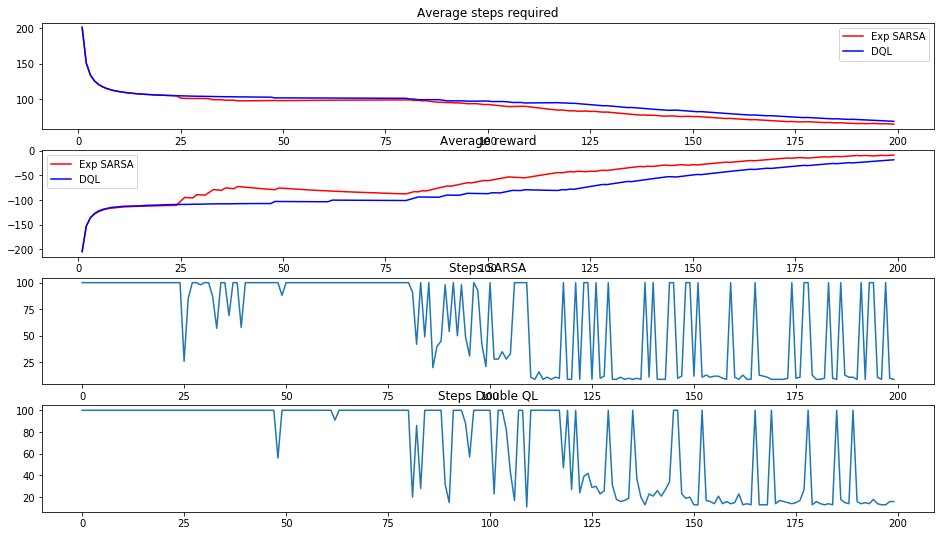

In [187]:
import matplotlib.pyplot as plt
height=25
width=25

plt.rcParams["figure.figsize"] = [16,9]
fig = plt.figure()
x=[i for i in range(episodes)]
#create 3x2 grid, put in the first location (1,1)
plt1 = fig.add_subplot(4,1,1)
plt1.plot(x, averageStepsExpSARSA, 'r-', label="Exp SARSA")
plt1.plot(x, averageStepsDoubQL, 'b-', label="DQL")
plt1.set_title("Average steps required")
plt1.legend(loc=0)

plt2 = fig.add_subplot(4,1,2)
plt2.plot(x, averageRewardExpSARSA, 'r-', label="Exp SARSA")
plt2.plot(x, averageRewardDoubQL, 'b-', label="DQL")
plt2.set_title("Average reward")
plt2.legend(loc=0)

plt3 = fig.add_subplot(4,1,3)
plt3.plot(x, stepsEpisodesExpSARSA)
plt3.set_title("Steps SARSA")

plt4 = fig.add_subplot(4,1,4)
plt4.plot(x, stepsEpisodesDoubQL)
plt4.set_title("Steps Double QL")

plt.show()

Expected SARSA seems behave a little bit better then Double QL. Interestingly, after around the 25 episode, ExpSARSA found a path to reach the goal, but next it seems not be able to use it again. Probabily, at the next timestep it tried again but due to e-policy it is finished on a red block and the value decreased making that action not worthy anymore. This is strange because expected SARSA should avoid this kind of evaluation. If an action that has not the highest value is selected (it is not the optimal action in the state) it should affect the estimate less, due to the expected value of q(s',a').

Another interesting thing is that around episode 75, they both seem to find a path to reach the goal. However, looking at the second graph, expected SARSA use it more often because its averaged reward increase more rapidly than Double QL.  Double QL starts to actually follow the path around episode 125/140, while Expected SARSA around 110.

Finally, Double QL seems to fall into red blocks less often, because it has less peaks in the steps graph compared to the SARSA one. The reason I think is due to the fact that Double QL has choose as optimal path a safety one. 